In [1]:

import os

import pandas as pd

from base.model import Model
from base.model_manager import ModelManager
from base.model_trainer import ModelTrainer
from base.training import mse_weighted
from common.model_utils import save_model, load_model_from_savemodel

if mse_weighted:
    print("mse_weighted loaded")

models_dir = "models"
model_trainer = ModelTrainer()
model_manager = ModelManager(models_dir, "zamg_vienna_2010_2019_simple_dense")



Using mse_weighted
mse_weighted loaded


In [2]:
from keras.src.callbacks import History
import matplotlib.pyplot as plt


def plot_history(history: History, model_name: str):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')

    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [3]:
from keras.src.callbacks import History

simple_dense = load_model_from_savemodel(os.path.join(models_dir, "zamg_vienna_2019_2019_simple_dense"))


def train_and_save_simple_dense(model_id: str, train_df: pd.DataFrame) -> (Model, History):
    new_model, history = model_trainer.retrain_model(
        model=simple_dense,
        data=train_df,
        epochs=100,
        patience=20,
        validation=0.3,
        stride=1,
        optimizer='rmsprop',
        learning_rate=0.002399431372613329
    )
    new_model.metadata.uuid = model_id
    save_model(new_model, os.path.join(models_dir, model_id))
    return new_model, history


simple_dense.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4, 8)              0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense1 (Dense)              (None, 16)                528       
                                                                 
 dense2 (Dense)              (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
data = pd.read_pickle("data/linz_2019_2019.pickle")
linz_2019_2019_simple_dense, training_history = train_and_save_simple_dense(
    "linz_2019_2019_simple_dense", data
)

linz_2019_2019_simple_dense.model.summary()

Epoch 1/100
188/188 [==============================] - 1s 4ms/step - loss: 1.2926 - mean_squared_error: 0.3058 - mean_absolute_error: 0.4013 - root_mean_squared_error: 0.5530 - val_loss: 0.4880 - val_mean_squared_error: 0.1194 - val_mean_absolute_error: 0.2676 - val_root_mean_squared_error: 0.3455 - lr: 0.0024
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 0.3805 - mean_squared_error: 0.0926 - mean_absolute_error: 0.2335 - root_mean_squared_error: 0.3044 - val_loss: 0.4254 - val_mean_squared_error: 0.0987 - val_mean_absolute_error: 0.2379 - val_root_mean_squared_error: 0.3141 - lr: 0.0024
Epoch 3/100
188/188 [==============================] - 0s 927us/step - loss: 0.3370 - mean_squared_error: 0.0829 - mean_absolute_error: 0.2189 - root_mean_squared_error: 0.2879 - val_loss: 0.3703 - val_mean_squared_error: 0.0872 - val_mean_absolute_error: 0.2208 - val_root_mean_squared_error: 0.2954 - lr: 0.0024
Epoch 4/100
188/188 [==============================] - 0s 975u

INFO:tensorflow:Assets written to: models\linz_2019_2019_simple_dense\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp3p4mki3t\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp3p4mki3t\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4, 8)              0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense1 (Dense)              (None, 16)                528       
                                                                 
 dense2 (Dense)              (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


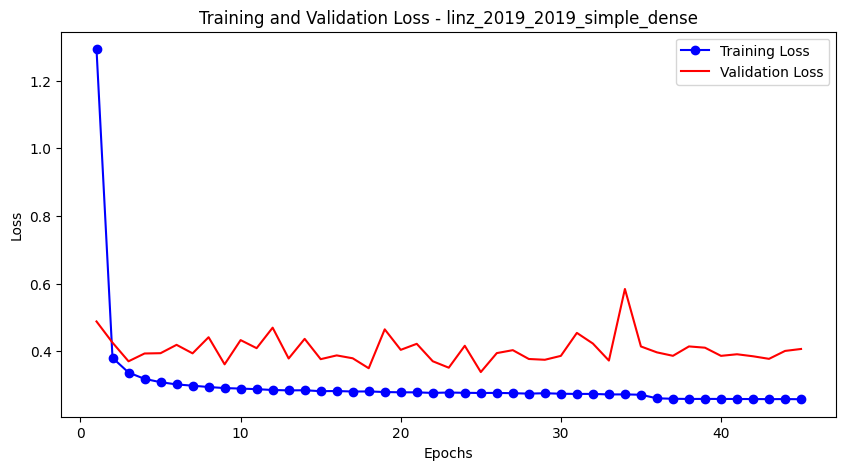

In [5]:
plot_history(training_history, "linz_2019_2019_simple_dense")

In [7]:
data = pd.read_pickle("data/vienna_2017_2019.pickle")
vienna_2017_2019_simple_dense, training_history = train_and_save_simple_dense(
    "vienna_2017_2019_simple_dense", data
)

vienna_2017_2019_simple_dense.model.summary()

Epoch 1/100
571/571 [==============================] - 1s 1ms/step - loss: 0.5965 - mean_squared_error: 0.1368 - mean_absolute_error: 0.2517 - root_mean_squared_error: 0.3699 - val_loss: 0.2828 - val_mean_squared_error: 0.0714 - val_mean_absolute_error: 0.2005 - val_root_mean_squared_error: 0.2672 - lr: 0.0024
Epoch 2/100
571/571 [==============================] - 1s 887us/step - loss: 0.2437 - mean_squared_error: 0.0635 - mean_absolute_error: 0.1854 - root_mean_squared_error: 0.2520 - val_loss: 0.2636 - val_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.1935 - val_root_mean_squared_error: 0.2591 - lr: 0.0024
Epoch 3/100
571/571 [==============================] - 1s 869us/step - loss: 0.2348 - mean_squared_error: 0.0618 - mean_absolute_error: 0.1821 - root_mean_squared_error: 0.2486 - val_loss: 0.2542 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.1901 - val_root_mean_squared_error: 0.2570 - lr: 0.0024
Epoch 4/100
571/571 [==============================] - 1s 88

INFO:tensorflow:Assets written to: models\vienna_2017_2019_simple_dense\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpcaz38izv\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpcaz38izv\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4, 8)              0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense1 (Dense)              (None, 16)                528       
                                                                 
 dense2 (Dense)              (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


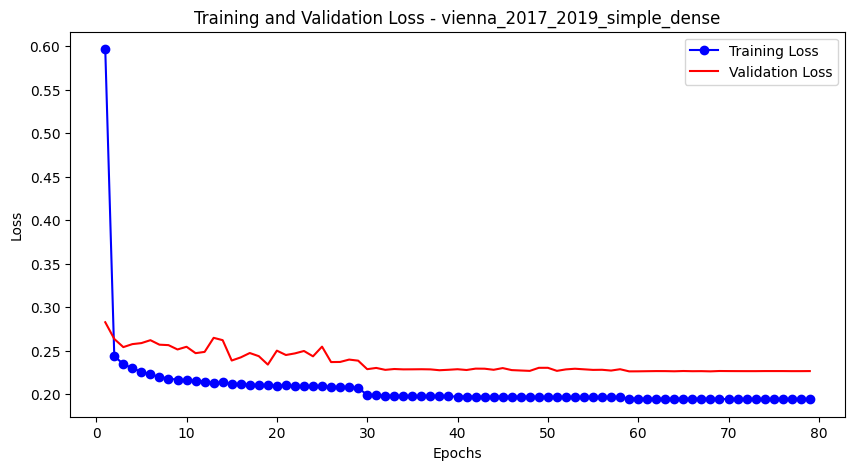

In [8]:
plot_history(training_history, "vienna_2017_2019_simple_dense")

In [10]:
data = pd.read_pickle("data/vienna_winter_2017_2019.pickle")
vienna_winter_2017_2019_simple_dense, training_history = train_and_save_simple_dense(
    simple_dense, "vienna_winter_2017_2019_simple_dense", data
)

vienna_winter_2017_2019_simple_dense.model.summary()

Epoch 1/100
187/187 [==============================] - 1s 3ms/step - loss: 1.9888 - mean_squared_error: 0.4428 - mean_absolute_error: 0.4763 - root_mean_squared_error: 0.6654 - val_loss: 1.1286 - val_mean_squared_error: 0.2907 - val_mean_absolute_error: 0.3920 - val_root_mean_squared_error: 0.5391 - lr: 0.0024
Epoch 2/100
187/187 [==============================] - 0s 950us/step - loss: 0.7504 - mean_squared_error: 0.2057 - mean_absolute_error: 0.3282 - root_mean_squared_error: 0.4535 - val_loss: 0.9902 - val_mean_squared_error: 0.2630 - val_mean_absolute_error: 0.3680 - val_root_mean_squared_error: 0.5129 - lr: 0.0024
Epoch 3/100
187/187 [==============================] - 0s 999us/step - loss: 0.6781 - mean_squared_error: 0.1909 - mean_absolute_error: 0.3140 - root_mean_squared_error: 0.4369 - val_loss: 0.9340 - val_mean_squared_error: 0.2534 - val_mean_absolute_error: 0.3581 - val_root_mean_squared_error: 0.5034 - lr: 0.0024
Epoch 4/100
187/187 [==============================] - 0s 95

INFO:tensorflow:Assets written to: models\vienna_winter_2017_2019_simple_dense\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpoi2wfd3n\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpoi2wfd3n\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4, 8)              0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense1 (Dense)              (None, 16)                528       
                                                                 
 dense2 (Dense)              (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


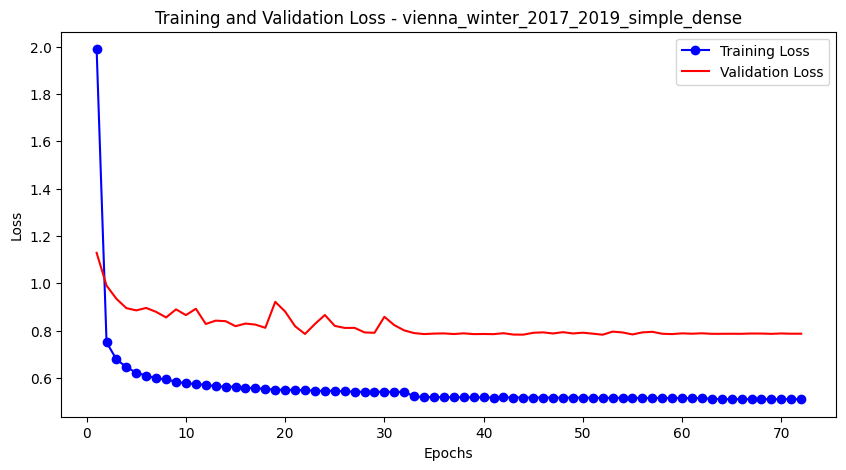

In [11]:
plot_history(training_history, "vienna_winter_2017_2019_simple_dense")

In [13]:
data = pd.read_pickle("data/vienna_spring_2017_2019.pickle")
vienna_spring_2017_2019_simple_dense, training_history = train_and_save_simple_dense(
    simple_dense, "vienna_spring_2017_2019_simple_dense", data
)

vienna_spring_2017_2019_simple_dense.model.summary()

Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 1.3957 - mean_squared_error: 0.3396 - mean_absolute_error: 0.4111 - root_mean_squared_error: 0.5828 - val_loss: 0.4861 - val_mean_squared_error: 0.1246 - val_mean_absolute_error: 0.2708 - val_root_mean_squared_error: 0.3529 - lr: 0.0024
Epoch 2/100
188/188 [==============================] - 0s 987us/step - loss: 0.5899 - mean_squared_error: 0.1593 - mean_absolute_error: 0.2740 - root_mean_squared_error: 0.3992 - val_loss: 0.4126 - val_mean_squared_error: 0.1066 - val_mean_absolute_error: 0.2489 - val_root_mean_squared_error: 0.3265 - lr: 0.0024
Epoch 3/100
188/188 [==============================] - 0s 991us/step - loss: 0.5473 - mean_squared_error: 0.1484 - mean_absolute_error: 0.2620 - root_mean_squared_error: 0.3853 - val_loss: 0.3795 - val_mean_squared_error: 0.0999 - val_mean_absolute_error: 0.2386 - val_root_mean_squared_error: 0.3161 - lr: 0.0024
Epoch 4/100
188/188 [==============================] - 0s 93

INFO:tensorflow:Assets written to: models\vienna_spring_2017_2019_simple_dense\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp881v4bi7\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp881v4bi7\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4, 8)              0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense1 (Dense)              (None, 16)                528       
                                                                 
 dense2 (Dense)              (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


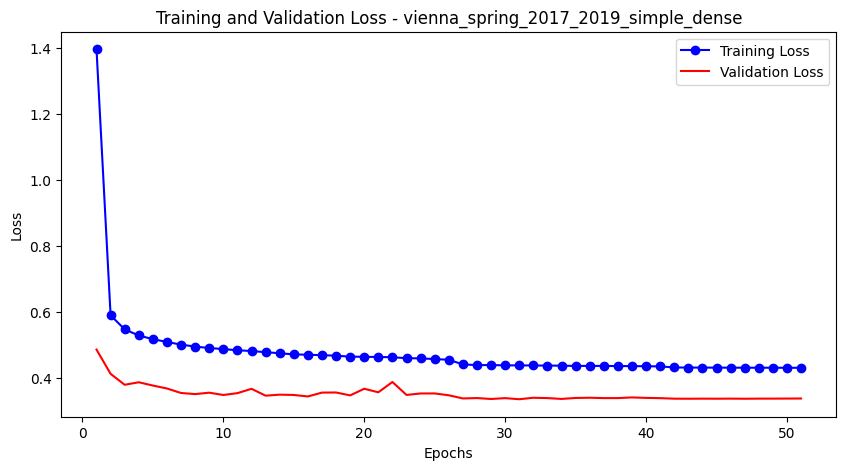

In [14]:
plot_history(training_history, "vienna_spring_2017_2019_simple_dense")

In [15]:
data = pd.read_pickle("data/vienna_summer_2017_2019.pickle")
vienna_summer_2017_2019_simple_dense, training_history = train_and_save_simple_dense(
    simple_dense, "vienna_summer_2017_2019_simple_dense", data
)

vienna_summer_2017_2019_simple_dense.model.summary()

Epoch 1/100
188/188 [==============================] - 1s 4ms/step - loss: 1.9325 - mean_squared_error: 0.4700 - mean_absolute_error: 0.5124 - root_mean_squared_error: 0.6856 - val_loss: 0.9539 - val_mean_squared_error: 0.2399 - val_mean_absolute_error: 0.3720 - val_root_mean_squared_error: 0.4898 - lr: 0.0024
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 0.9480 - mean_squared_error: 0.2383 - mean_absolute_error: 0.3602 - root_mean_squared_error: 0.4882 - val_loss: 0.8726 - val_mean_squared_error: 0.2203 - val_mean_absolute_error: 0.3536 - val_root_mean_squared_error: 0.4694 - lr: 0.0024
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 0.8953 - mean_squared_error: 0.2252 - mean_absolute_error: 0.3482 - root_mean_squared_error: 0.4746 - val_loss: 0.8462 - val_mean_squared_error: 0.2148 - val_mean_absolute_error: 0.3503 - val_root_mean_squared_error: 0.4635 - lr: 0.0024
Epoch 4/100
188/188 [==============================] - 0s 1ms/st

INFO:tensorflow:Assets written to: models\vienna_summer_2017_2019_simple_dense\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp27_59f37\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp27_59f37\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4, 8)              0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense1 (Dense)              (None, 16)                528       
                                                                 
 dense2 (Dense)              (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


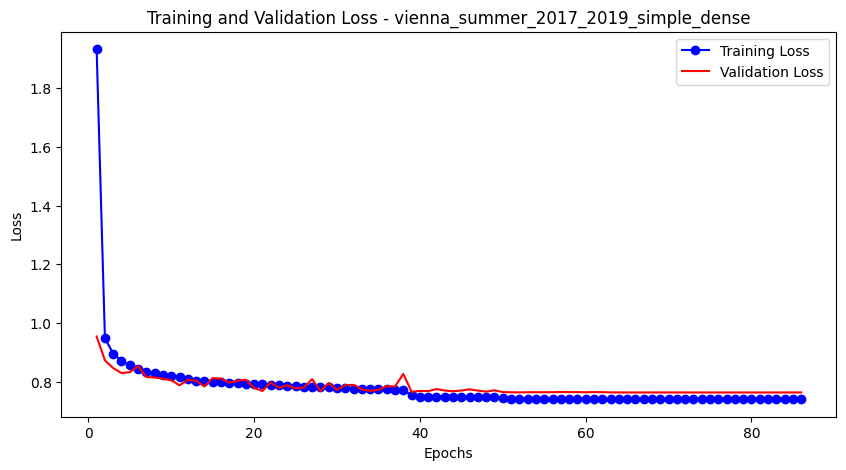

In [16]:
plot_history(training_history, "vienna_summer_2017_2019_simple_dense")

In [17]:
data = pd.read_pickle("data/vienna_autumn_2017_2019.pickle")
vienna_autumn_2017_2019_simple_dense, training_history = train_and_save_simple_dense(
    simple_dense, "vienna_autumn_2017_2019_simple_dense", data
)

vienna_autumn_2017_2019_simple_dense.model.summary()

Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 1.5283 - mean_squared_error: 0.3452 - mean_absolute_error: 0.4174 - root_mean_squared_error: 0.5875 - val_loss: 0.5189 - val_mean_squared_error: 0.1353 - val_mean_absolute_error: 0.2746 - val_root_mean_squared_error: 0.3678 - lr: 0.0024
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 0.5071 - mean_squared_error: 0.1342 - mean_absolute_error: 0.2573 - root_mean_squared_error: 0.3664 - val_loss: 0.4457 - val_mean_squared_error: 0.1183 - val_mean_absolute_error: 0.2550 - val_root_mean_squared_error: 0.3440 - lr: 0.0024
Epoch 3/100
188/188 [==============================] - 0s 977us/step - loss: 0.4657 - mean_squared_error: 0.1251 - mean_absolute_error: 0.2457 - root_mean_squared_error: 0.3537 - val_loss: 0.4283 - val_mean_squared_error: 0.1150 - val_mean_absolute_error: 0.2461 - val_root_mean_squared_error: 0.3391 - lr: 0.0024
Epoch 4/100
188/188 [==============================] - 0s 1ms/

INFO:tensorflow:Assets written to: models\vienna_autumn_2017_2019_simple_dense\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp8z8ami7d\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp8z8ami7d\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 4, 8)              0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense1 (Dense)              (None, 16)                528       
                                                                 
 dense2 (Dense)              (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


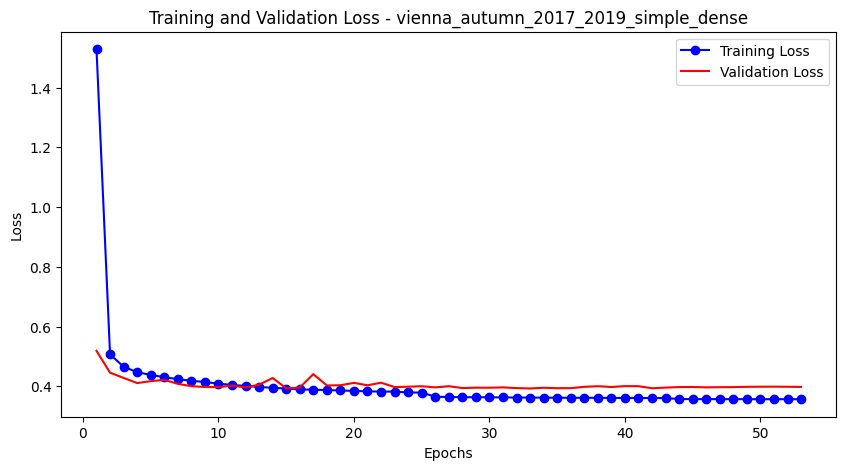

In [18]:
plot_history(training_history, "vienna_autumn_2017_2019_simple_dense")

In [5]:
simple_lstm = load_model_from_savemodel(os.path.join(models_dir, "zamg_vienna_2019_2019_simple_lstm"))


def train_and_save_simple_lstm(model_id: str, train_df: pd.DataFrame) -> (Model, History):
    new_model, history = model_trainer.retrain_model(
        model=simple_lstm,
        data=train_df,
        epochs=100,
        patience=20,
        validation=0.3,
        stride=1,
        optimizer='rmsprop',
        learning_rate=0.0005028709561526049,
    )
    new_model.metadata.uuid = model_id
    save_model(new_model, os.path.join(models_dir, model_id))
    return new_model, history


simple_lstm.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 6040 (23.59 KB)
Trainable params: 6040 (23.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
data = pd.read_pickle("data/vienna_2017_2019.pickle")
vienna_2017_2019_simple_lstm, training_history = train_and_save_simple_lstm(
    "vienna_2017_2019_simple_lstm", data
)

vienna_2017_2019_simple_lstm.model.summary()

Epoch 1/100
571/571 [==============================] - 5s 7ms/step - loss: 0.9152 - mean_squared_error: 0.2139 - mean_absolute_error: 0.3340 - root_mean_squared_error: 0.4625 - val_loss: 0.3022 - val_mean_squared_error: 0.0779 - val_mean_absolute_error: 0.2124 - val_root_mean_squared_error: 0.2791 - lr: 5.0287e-04
Epoch 2/100
571/571 [==============================] - 3s 6ms/step - loss: 0.3105 - mean_squared_error: 0.0779 - mean_absolute_error: 0.2110 - root_mean_squared_error: 0.2791 - val_loss: 0.2652 - val_mean_squared_error: 0.0677 - val_mean_absolute_error: 0.1972 - val_root_mean_squared_error: 0.2602 - lr: 5.0287e-04
Epoch 3/100
571/571 [==============================] - 4s 6ms/step - loss: 0.2769 - mean_squared_error: 0.0702 - mean_absolute_error: 0.1986 - root_mean_squared_error: 0.2650 - val_loss: 0.2535 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.1914 - val_root_mean_squared_error: 0.2552 - lr: 5.0287e-04
Epoch 4/100
571/571 [==============================]

INFO:tensorflow:Assets written to: models\vienna_2017_2019_simple_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpxjzdlg01\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpxjzdlg01\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 6040 (23.59 KB)
Trainable params: 6040 (23.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


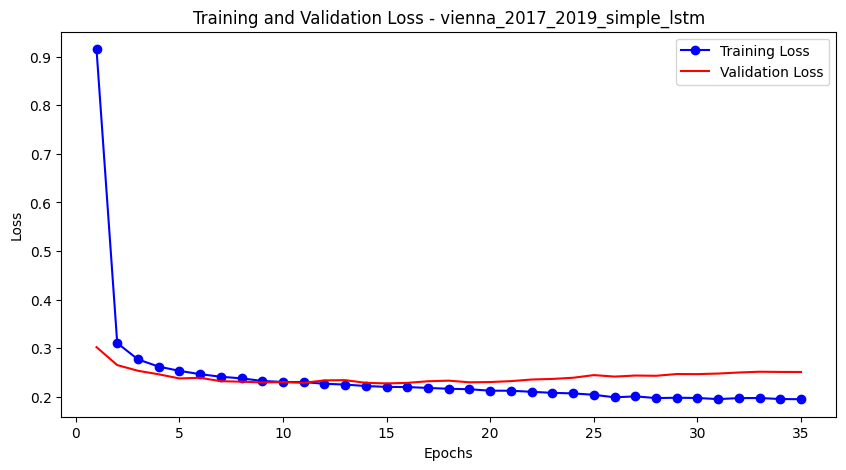

In [7]:
plot_history(training_history, "vienna_2017_2019_simple_lstm")

In [7]:
data = pd.read_pickle("data/linz_2019_2019.pickle")
linz_2019_2019_simple_lstm, training_history = train_and_save_simple_lstm(
    "linz_2019_2019_simple_lstm", data
)

linz_2019_2019_simple_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 2.4776 - mean_squared_error: 0.5408 - mean_absolute_error: 0.5733 - root_mean_squared_error: 0.7354 - val_loss: 0.7151 - val_mean_squared_error: 0.1761 - val_mean_absolute_error: 0.3312 - val_root_mean_squared_error: 0.4196 - lr: 5.0287e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 0.6604 - mean_squared_error: 0.1699 - mean_absolute_error: 0.3209 - root_mean_squared_error: 0.4122 - val_loss: 0.5582 - val_mean_squared_error: 0.1295 - val_mean_absolute_error: 0.2772 - val_root_mean_squared_error: 0.3598 - lr: 5.0287e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 0.4551 - mean_squared_error: 0.1159 - mean_absolute_error: 0.2628 - root_mean_squared_error: 0.3404 - val_loss: 0.4978 - val_mean_squared_error: 0.1157 - val_mean_absolute_error: 0.2599 - val_root_mean_squared_error: 0.3401 - lr: 5.0287e-04
Epoch 4/100
188/188 [==============================]

INFO:tensorflow:Assets written to: models\linz_2019_2019_simple_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmprkbx_ovi\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmprkbx_ovi\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 6040 (23.59 KB)
Trainable params: 6040 (23.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


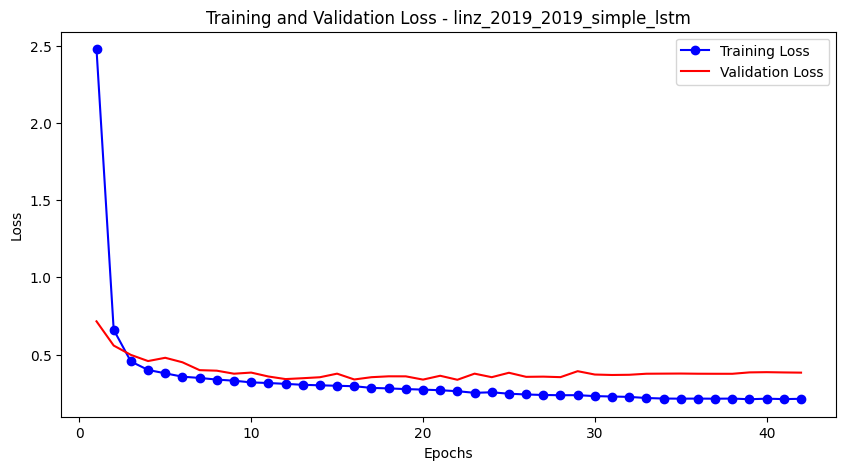

In [8]:
plot_history(training_history, "linz_2019_2019_simple_lstm")

In [18]:
data = pd.read_pickle("data/vienna_winter_2017_2019.pickle")
vienna_winter_2017_2019_simple_lstm, training_history = train_and_save_simple_lstm(
    "vienna_winter_2017_2019_simple_lstm", data
)

vienna_winter_2017_2019_simple_lstm.model.summary()

Epoch 1/100
187/187 [==============================] - 3s 8ms/step - loss: 2.5825 - mean_squared_error: 0.5647 - mean_absolute_error: 0.5608 - root_mean_squared_error: 0.7514 - val_loss: 1.5291 - val_mean_squared_error: 0.3734 - val_mean_absolute_error: 0.4517 - val_root_mean_squared_error: 0.6110 - lr: 5.0287e-04
Epoch 2/100
187/187 [==============================] - 1s 6ms/step - loss: 1.0365 - mean_squared_error: 0.2614 - mean_absolute_error: 0.3785 - root_mean_squared_error: 0.5112 - val_loss: 1.1621 - val_mean_squared_error: 0.2989 - val_mean_absolute_error: 0.4027 - val_root_mean_squared_error: 0.5467 - lr: 5.0287e-04
Epoch 3/100
187/187 [==============================] - 1s 6ms/step - loss: 0.8449 - mean_squared_error: 0.2230 - mean_absolute_error: 0.3462 - root_mean_squared_error: 0.4722 - val_loss: 1.0367 - val_mean_squared_error: 0.2713 - val_mean_absolute_error: 0.3796 - val_root_mean_squared_error: 0.5209 - lr: 5.0287e-04
Epoch 4/100
187/187 [==============================]

INFO:tensorflow:Assets written to: models\vienna_winter_2017_2019_simple_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp4it92auu\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp4it92auu\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 6040 (23.59 KB)
Trainable params: 6040 (23.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


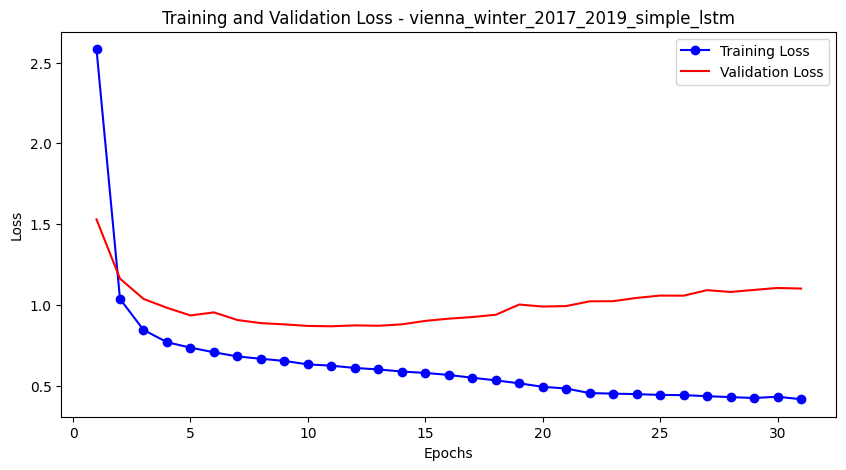

In [19]:
plot_history(training_history, "vienna_winter_2017_2019_simple_lstm")

In [20]:
data = pd.read_pickle("data/vienna_spring_2017_2019.pickle")
vienna_spring_2017_2019_simple_lstm, training_history = train_and_save_simple_lstm(
    "vienna_spring_2017_2019_simple_lstm", data
)

vienna_spring_2017_2019_simple_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 2.9192 - mean_squared_error: 0.6300 - mean_absolute_error: 0.6061 - root_mean_squared_error: 0.7937 - val_loss: 1.1347 - val_mean_squared_error: 0.2727 - val_mean_absolute_error: 0.4110 - val_root_mean_squared_error: 0.5223 - lr: 5.0287e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.0103 - mean_squared_error: 0.2541 - mean_absolute_error: 0.3712 - root_mean_squared_error: 0.5041 - val_loss: 0.5702 - val_mean_squared_error: 0.1539 - val_mean_absolute_error: 0.3043 - val_root_mean_squared_error: 0.3923 - lr: 5.0287e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 0.7047 - mean_squared_error: 0.1837 - mean_absolute_error: 0.3071 - root_mean_squared_error: 0.4286 - val_loss: 0.4333 - val_mean_squared_error: 0.1163 - val_mean_absolute_error: 0.2628 - val_root_mean_squared_error: 0.3411 - lr: 5.0287e-04
Epoch 4/100
188/188 [==============================]

INFO:tensorflow:Assets written to: models\vienna_spring_2017_2019_simple_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpoln9ayi5\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpoln9ayi5\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 6040 (23.59 KB)
Trainable params: 6040 (23.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


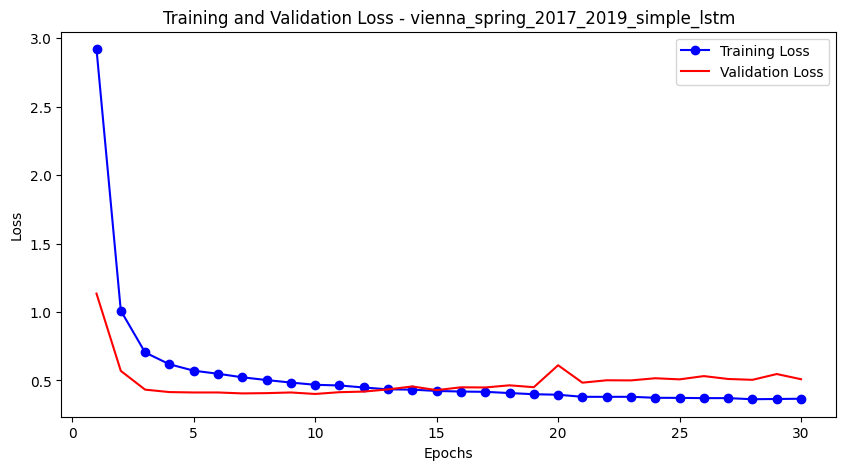

In [21]:
plot_history(training_history, "vienna_spring_2017_2019_simple_lstm")

In [22]:
data = pd.read_pickle("data/vienna_summer_2017_2019.pickle")
vienna_summer_2017_2019_simple_lstm, training_history = train_and_save_simple_lstm(
    "vienna_summer_2017_2019_simple_lstm", data
)

vienna_summer_2017_2019_simple_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 3s 9ms/step - loss: 3.1693 - mean_squared_error: 0.6852 - mean_absolute_error: 0.6587 - root_mean_squared_error: 0.8278 - val_loss: 1.5493 - val_mean_squared_error: 0.3765 - val_mean_absolute_error: 0.4828 - val_root_mean_squared_error: 0.6136 - lr: 5.0287e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3275 - mean_squared_error: 0.3287 - mean_absolute_error: 0.4431 - root_mean_squared_error: 0.5734 - val_loss: 1.0106 - val_mean_squared_error: 0.2518 - val_mean_absolute_error: 0.3905 - val_root_mean_squared_error: 0.5018 - lr: 5.0287e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.0583 - mean_squared_error: 0.2595 - mean_absolute_error: 0.3861 - root_mean_squared_error: 0.5094 - val_loss: 0.9035 - val_mean_squared_error: 0.2249 - val_mean_absolute_error: 0.3639 - val_root_mean_squared_error: 0.4742 - lr: 5.0287e-04
Epoch 4/100
188/188 [==============================]

INFO:tensorflow:Assets written to: models\vienna_summer_2017_2019_simple_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp17h0pvb1\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp17h0pvb1\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 6040 (23.59 KB)
Trainable params: 6040 (23.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


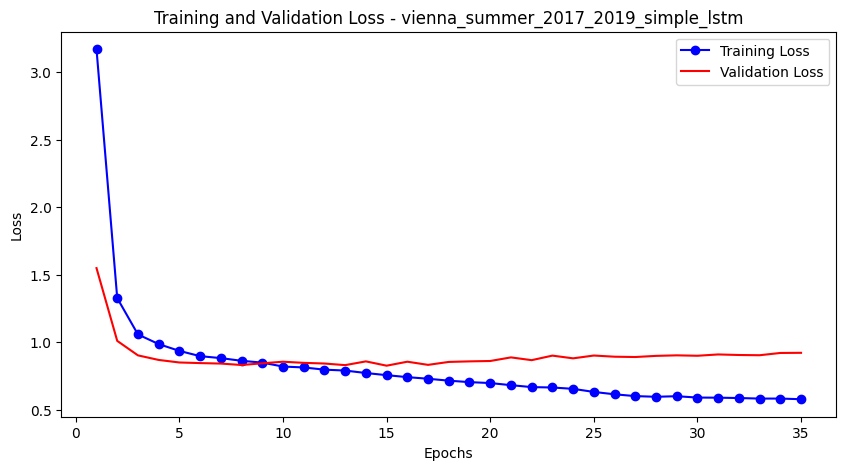

In [23]:
plot_history(training_history, "vienna_summer_2017_2019_simple_lstm")

In [24]:
data = pd.read_pickle("data/vienna_autumn_2017_2019.pickle")
vienna_autumn_2017_2019_simple_lstm, training_history = train_and_save_simple_lstm(
    "vienna_autumn_2017_2019_simple_lstm", data
)

vienna_summer_2017_2019_simple_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 2s 7ms/step - loss: 2.2513 - mean_squared_error: 0.4957 - mean_absolute_error: 0.5361 - root_mean_squared_error: 0.7041 - val_loss: 0.7841 - val_mean_squared_error: 0.1961 - val_mean_absolute_error: 0.3418 - val_root_mean_squared_error: 0.4428 - lr: 5.0287e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 0.7964 - mean_squared_error: 0.2007 - mean_absolute_error: 0.3288 - root_mean_squared_error: 0.4480 - val_loss: 0.6019 - val_mean_squared_error: 0.1548 - val_mean_absolute_error: 0.2955 - val_root_mean_squared_error: 0.3934 - lr: 5.0287e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 0.6194 - mean_squared_error: 0.1590 - mean_absolute_error: 0.2867 - root_mean_squared_error: 0.3988 - val_loss: 0.5186 - val_mean_squared_error: 0.1343 - val_mean_absolute_error: 0.2737 - val_root_mean_squared_error: 0.3665 - lr: 5.0287e-04
Epoch 4/100
188/188 [==============================]

INFO:tensorflow:Assets written to: models\vienna_autumn_2017_2019_simple_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpuipsn9p1\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpuipsn9p1\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 6040 (23.59 KB)
Trainable params: 6040 (23.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


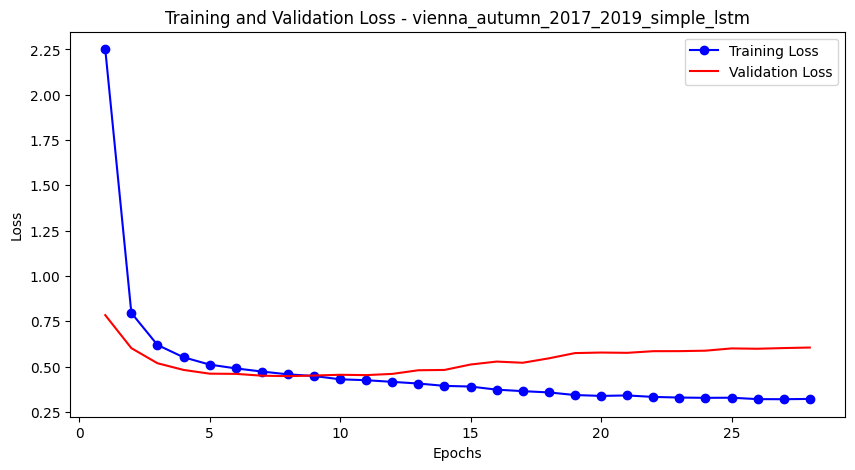

In [25]:
plot_history(training_history, "vienna_autumn_2017_2019_simple_lstm")

In [8]:
conv_lstm = load_model_from_savemodel(os.path.join(models_dir, "zamg_vienna_2019_2019_conv_lstm"))


def train_and_save_conv_lstm(model_id: str, train_df: pd.DataFrame) -> (Model, History):
    new_model, history = model_trainer.retrain_model(
        model=conv_lstm,
        data=train_df,
        epochs=100,
        patience=20,
        validation=0.3,
        stride=1,
        optimizer='adam',
        learning_rate=0.00024407154977751656,
    )
    new_model.metadata.uuid = model_id
    save_model(new_model, os.path.join(models_dir, model_id))
    return new_model, history


conv_lstm.model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 120, 24)           600       
                                                                 
 conv2 (Conv1D)              (None, 120, 32)           2336      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 60, 48)            4656      
                                                                 
 conv4 (Conv1D)              (None, 60, 64)            9280      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                 

In [9]:
data = pd.read_pickle("data/vienna_2017_2019.pickle")
vienna_2017_2019_conv_lstm, training_history = train_and_save_conv_lstm(
    "vienna_2017_2019_conv_lstm", data
)

vienna_2017_2019_conv_lstm.model.summary()

Epoch 1/100
571/571 [==============================] - 7s 9ms/step - loss: 1.1505 - mean_squared_error: 0.2830 - mean_absolute_error: 0.3816 - root_mean_squared_error: 0.5319 - val_loss: 0.3700 - val_mean_squared_error: 0.0975 - val_mean_absolute_error: 0.2385 - val_root_mean_squared_error: 0.3123 - lr: 2.4407e-04
Epoch 2/100
571/571 [==============================] - 5s 8ms/step - loss: 0.3053 - mean_squared_error: 0.0801 - mean_absolute_error: 0.2128 - root_mean_squared_error: 0.2831 - val_loss: 0.2974 - val_mean_squared_error: 0.0769 - val_mean_absolute_error: 0.2096 - val_root_mean_squared_error: 0.2774 - lr: 2.4407e-04
Epoch 3/100
571/571 [==============================] - 5s 9ms/step - loss: 0.2566 - mean_squared_error: 0.0675 - mean_absolute_error: 0.1934 - root_mean_squared_error: 0.2599 - val_loss: 0.2819 - val_mean_squared_error: 0.0721 - val_mean_absolute_error: 0.2021 - val_root_mean_squared_error: 0.2685 - lr: 2.4407e-04
Epoch 4/100
571/571 [==============================]

INFO:tensorflow:Assets written to: models\vienna_2017_2019_conv_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpfc9252p8\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpfc9252p8\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 120, 24)           600       
                                                                 
 conv2 (Conv1D)              (None, 120, 32)           2336      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 60, 48)            4656      
                                                                 
 conv4 (Conv1D)              (None, 60, 64)            9280      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                 

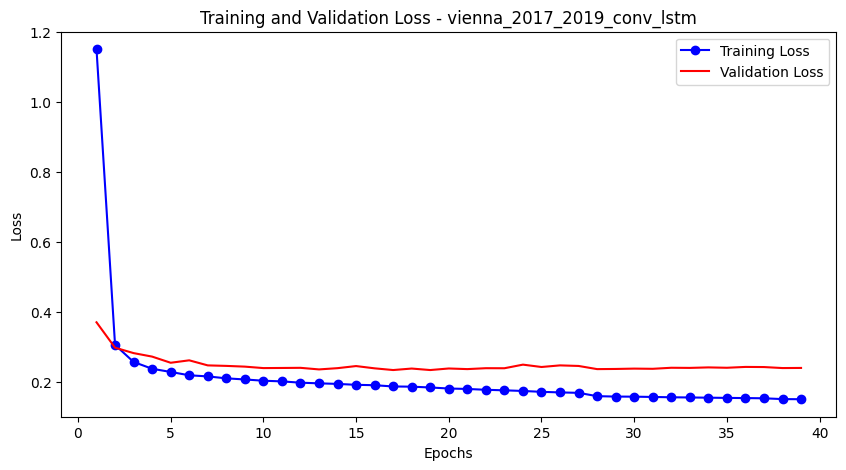

In [10]:
plot_history(training_history, "vienna_2017_2019_conv_lstm")

In [10]:
data = pd.read_pickle("data/linz_2019_2019.pickle")
linz_2019_2019_conv_lstm, training_history = train_and_save_conv_lstm(
    "linz_2019_2019_conv_lstm", data
)

linz_2019_2019_conv_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 3s 10ms/step - loss: 2.1283 - mean_squared_error: 0.5436 - mean_absolute_error: 0.5701 - root_mean_squared_error: 0.7373 - val_loss: 0.7429 - val_mean_squared_error: 0.2169 - val_mean_absolute_error: 0.3560 - val_root_mean_squared_error: 0.4657 - lr: 2.4407e-04
Epoch 2/100
188/188 [==============================] - 1s 8ms/step - loss: 0.6879 - mean_squared_error: 0.2050 - mean_absolute_error: 0.3424 - root_mean_squared_error: 0.4528 - val_loss: 0.5726 - val_mean_squared_error: 0.1422 - val_mean_absolute_error: 0.2871 - val_root_mean_squared_error: 0.3771 - lr: 2.4407e-04
Epoch 3/100
188/188 [==============================] - 2s 8ms/step - loss: 0.4710 - mean_squared_error: 0.1340 - mean_absolute_error: 0.2790 - root_mean_squared_error: 0.3661 - val_loss: 0.6007 - val_mean_squared_error: 0.1378 - val_mean_absolute_error: 0.2829 - val_root_mean_squared_error: 0.3713 - lr: 2.4407e-04
Epoch 4/100
188/188 [==============================

INFO:tensorflow:Assets written to: models\linz_2019_2019_conv_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpfy26nqgt\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpfy26nqgt\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 120, 24)           600       
                                                                 
 conv2 (Conv1D)              (None, 120, 32)           2336      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 60, 48)            4656      
                                                                 
 conv4 (Conv1D)              (None, 60, 64)            9280      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                 

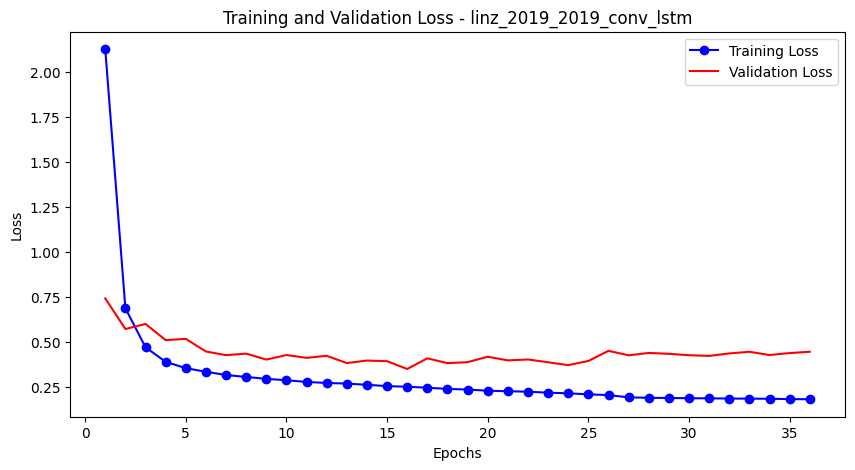

In [11]:
plot_history(training_history, "linz_2019_2019_conv_lstm")

In [27]:
data = pd.read_pickle("data/vienna_winter_2017_2019.pickle")
vienna_winter_2017_2019_conv_lstm, training_history = train_and_save_conv_lstm(
    "vienna_winter_2017_2019_conv_lstm", data
)

vienna_winter_2017_2019_conv_lstm.model.summary()

Epoch 1/100
187/187 [==============================] - 4s 13ms/step - loss: 2.5597 - mean_squared_error: 0.5568 - mean_absolute_error: 0.5588 - root_mean_squared_error: 0.7462 - val_loss: 1.8013 - val_mean_squared_error: 0.4314 - val_mean_absolute_error: 0.4925 - val_root_mean_squared_error: 0.6568 - lr: 2.4407e-04
Epoch 2/100
187/187 [==============================] - 2s 11ms/step - loss: 1.1845 - mean_squared_error: 0.2973 - mean_absolute_error: 0.4049 - root_mean_squared_error: 0.5452 - val_loss: 1.3510 - val_mean_squared_error: 0.3414 - val_mean_absolute_error: 0.4286 - val_root_mean_squared_error: 0.5843 - lr: 2.4407e-04
Epoch 3/100
187/187 [==============================] - 2s 11ms/step - loss: 0.8973 - mean_squared_error: 0.2370 - mean_absolute_error: 0.3572 - root_mean_squared_error: 0.4868 - val_loss: 1.1641 - val_mean_squared_error: 0.3018 - val_mean_absolute_error: 0.3978 - val_root_mean_squared_error: 0.5494 - lr: 2.4407e-04
Epoch 4/100
187/187 [============================

INFO:tensorflow:Assets written to: models\vienna_winter_2017_2019_conv_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmphreqd_py\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmphreqd_py\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 120, 24)           600       
                                                                 
 conv2 (Conv1D)              (None, 120, 32)           2336      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 60, 48)            4656      
                                                                 
 conv4 (Conv1D)              (None, 60, 64)            9280      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                 

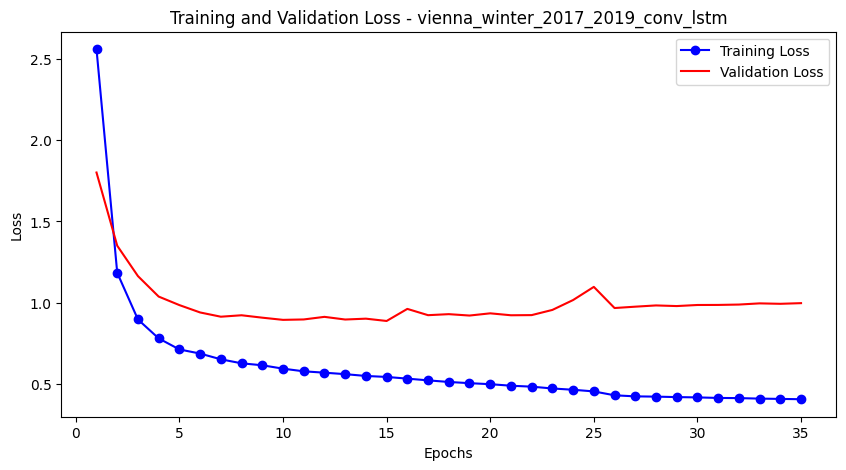

In [28]:
plot_history(training_history, "vienna_winter_2017_2019_conv_lstm")

In [29]:
data = pd.read_pickle("data/vienna_spring_2017_2019.pickle")
vienna_spring_2017_2019_conv_lstm, training_history = train_and_save_conv_lstm(
    "vienna_spring_2017_2019_conv_lstm", data
)

vienna_spring_2017_2019_conv_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 4s 12ms/step - loss: 2.5193 - mean_squared_error: 0.6126 - mean_absolute_error: 0.5962 - root_mean_squared_error: 0.7827 - val_loss: 1.1855 - val_mean_squared_error: 0.3297 - val_mean_absolute_error: 0.4436 - val_root_mean_squared_error: 0.5742 - lr: 2.4407e-04
Epoch 2/100
188/188 [==============================] - 2s 10ms/step - loss: 1.0886 - mean_squared_error: 0.3070 - mean_absolute_error: 0.4025 - root_mean_squared_error: 0.5540 - val_loss: 0.6738 - val_mean_squared_error: 0.1927 - val_mean_absolute_error: 0.3338 - val_root_mean_squared_error: 0.4389 - lr: 2.4407e-04
Epoch 3/100
188/188 [==============================] - 2s 10ms/step - loss: 0.7759 - mean_squared_error: 0.2215 - mean_absolute_error: 0.3355 - root_mean_squared_error: 0.4706 - val_loss: 0.5382 - val_mean_squared_error: 0.1493 - val_mean_absolute_error: 0.2947 - val_root_mean_squared_error: 0.3864 - lr: 2.4407e-04
Epoch 4/100
188/188 [============================

INFO:tensorflow:Assets written to: models\vienna_spring_2017_2019_conv_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp6m6d8s7s\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp6m6d8s7s\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 120, 24)           600       
                                                                 
 conv2 (Conv1D)              (None, 120, 32)           2336      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 60, 48)            4656      
                                                                 
 conv4 (Conv1D)              (None, 60, 64)            9280      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                 

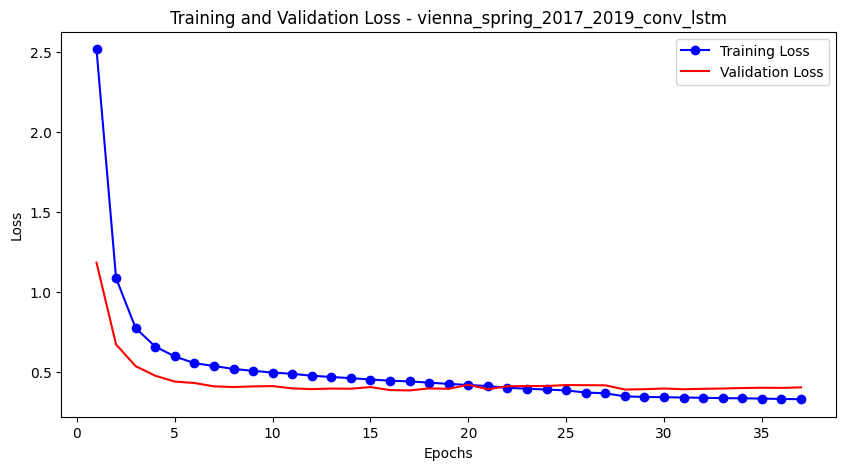

In [30]:
plot_history(training_history, "vienna_spring_2017_2019_conv_lstm")

In [31]:
data = pd.read_pickle("data/vienna_summer_2017_2019.pickle")
vienna_summer_2017_2019_conv_lstm, training_history = train_and_save_conv_lstm(
    "vienna_summer_2017_2019_conv_lstm", data
)

vienna_summer_2017_2019_conv_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 4s 13ms/step - loss: 2.9668 - mean_squared_error: 0.6617 - mean_absolute_error: 0.6458 - root_mean_squared_error: 0.8135 - val_loss: 1.5652 - val_mean_squared_error: 0.4059 - val_mean_absolute_error: 0.4960 - val_root_mean_squared_error: 0.6371 - lr: 2.4407e-04
Epoch 2/100
188/188 [==============================] - 2s 11ms/step - loss: 1.4132 - mean_squared_error: 0.3689 - mean_absolute_error: 0.4684 - root_mean_squared_error: 0.6074 - val_loss: 1.1528 - val_mean_squared_error: 0.2978 - val_mean_absolute_error: 0.4221 - val_root_mean_squared_error: 0.5457 - lr: 2.4407e-04
Epoch 3/100
188/188 [==============================] - 2s 11ms/step - loss: 1.1300 - mean_squared_error: 0.2919 - mean_absolute_error: 0.4104 - root_mean_squared_error: 0.5403 - val_loss: 1.0161 - val_mean_squared_error: 0.2590 - val_mean_absolute_error: 0.3902 - val_root_mean_squared_error: 0.5089 - lr: 2.4407e-04
Epoch 4/100
188/188 [============================

INFO:tensorflow:Assets written to: models\vienna_summer_2017_2019_conv_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp8vo248lp\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmp8vo248lp\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 120, 24)           600       
                                                                 
 conv2 (Conv1D)              (None, 120, 32)           2336      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 60, 48)            4656      
                                                                 
 conv4 (Conv1D)              (None, 60, 64)            9280      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                 

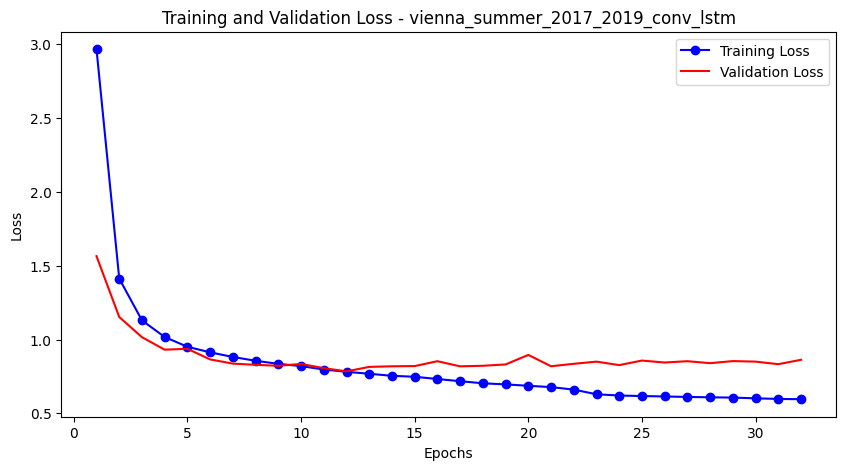

In [32]:
plot_history(training_history, "vienna_summer_2017_2019_conv_lstm")

In [33]:
data = pd.read_pickle("data/vienna_autumn_2017_2019.pickle")
vienna_autumn_2017_2019_conv_lstm, training_history = train_and_save_conv_lstm(
    "vienna_autumn_2017_2019_conv_lstm", data
)

vienna_autumn_2017_2019_conv_lstm.model.summary()

Epoch 1/100
188/188 [==============================] - 6s 18ms/step - loss: 2.0251 - mean_squared_error: 0.4447 - mean_absolute_error: 0.5065 - root_mean_squared_error: 0.6669 - val_loss: 0.8909 - val_mean_squared_error: 0.2210 - val_mean_absolute_error: 0.3660 - val_root_mean_squared_error: 0.4701 - lr: 2.4407e-04
Epoch 2/100
188/188 [==============================] - 3s 14ms/step - loss: 0.9013 - mean_squared_error: 0.2237 - mean_absolute_error: 0.3489 - root_mean_squared_error: 0.4730 - val_loss: 0.6527 - val_mean_squared_error: 0.1711 - val_mean_absolute_error: 0.3158 - val_root_mean_squared_error: 0.4136 - lr: 2.4407e-04
Epoch 3/100
188/188 [==============================] - 3s 16ms/step - loss: 0.6835 - mean_squared_error: 0.1778 - mean_absolute_error: 0.3068 - root_mean_squared_error: 0.4216 - val_loss: 0.5695 - val_mean_squared_error: 0.1526 - val_mean_absolute_error: 0.2957 - val_root_mean_squared_error: 0.3906 - lr: 2.4407e-04
Epoch 4/100
188/188 [============================

INFO:tensorflow:Assets written to: models\vienna_autumn_2017_2019_conv_lstm\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpliqtyv50\assets


INFO:tensorflow:Assets written to: C:\Users\gabri\AppData\Local\Temp\tmpliqtyv50\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 120, 24)           600       
                                                                 
 conv2 (Conv1D)              (None, 120, 32)           2336      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 32)            0         
 g1D)                                                            
                                                                 
 conv3 (Conv1D)              (None, 60, 48)            4656      
                                                                 
 conv4 (Conv1D)              (None, 60, 64)            9280      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                 

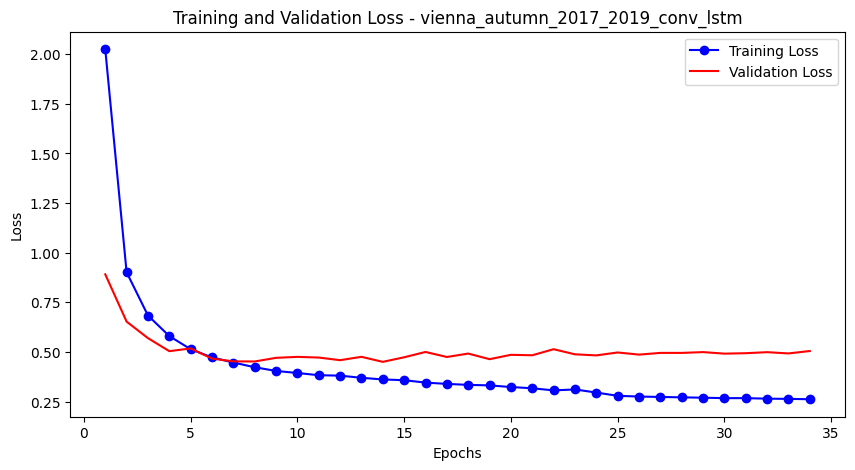

In [34]:
plot_history(training_history, "vienna_autumn_2017_2019_conv_lstm")